# Training CNN for crowd level classification

The model takes in pictures of the bus stop, classified into their respective crowd levels.
These classified images then is fed into the model to train. The output model can then be used to classify the existing state of the bus stop.

Folder Structure:
```
/home/root/my_project_training/
│
├── 0_empty/
│   ├── empty_01.jpg
│   ├── empty_02.jpg
│   └── ...
│
├── 1_low/
│   ├── 1_low_01.jpg
│   └── ...
│
└── 2_medium/
    ├── 2_medium_01.jpg
    └── ...
```

Install dependencies:

In [43]:
pip install torch torchvision numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Import libraries:

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import json
import os
import sys # Added sys for exiting

# --- Define Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Define Data Transforms and Load Data

Add black bars to make it a square to enable transfer learning, MobileNetV2 needs square input.

Use data augmentation to create variations on the same dataset. 

In [45]:
# Custom transform to "letterbox" (pad) the image to a square
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = max(w, h)
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return transforms.functional.pad(image, padding, 0, 'constant')

# Create a separate transform pipeline for TRAINING ---
# This includes augmentations to create more varied data
train_transform = transforms.Compose([
    SquarePad(),                      # 1. Pad to be a square
    transforms.Resize((224, 224)),    # 2. Shrink to 224x224
    # --- NEW Augmentations ---
    transforms.RandomHorizontalFlip(p=0.5), # 3. Randomly flip images horizontally
    transforms.RandomRotation(10),          # 4. Randomly rotate by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # 5. Tweak colors
    # --- End Augmentations ---
    transforms.ToTensor(),            # 6. Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 7. Normalize
])

# Create a separate transform pipeline for VALIDATION/TESTING ---
# This has NO augmentation, just the required preprocessing
val_transform = transforms.Compose([
    SquarePad(),                      # 1. Pad to be a square
    transforms.Resize((224, 224)),    # 2. Shrink to 224x224
    transforms.ToTensor(),            # 3. Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 4. Normalize
])

Load image data for training and testing:

In [46]:
# --- Load Your Custom Data from Folders ---
# This is the PyTorch version of "image_dataset_from_directory"
# data_dir = '/home/root/my_project_training/'
data_dir = './train_combined/'
print(f"Loading all data from: {data_dir}")

# Load the dataset TWICE, once with each transform pipeline
# This is necessary so we can assign the correct transforms to the train/val splits
try:
    # Dataset for TRAINING (will be subset-ted later)
    full_dataset_train = datasets.ImageFolder(
        root=data_dir,
        transform=train_transform
    )
    
    # Dataset for VALIDATION (will be subset-ted later)
    # We use this one to get the class names and perform the split
    full_dataset_val = datasets.ImageFolder(
        root=data_dir,
        transform=val_transform
    )
except FileNotFoundError:
    print(f"Error: Data directory not found at {data_dir}")
    print("Please update the 'data_dir' variable to point to your dataset.")
    sys.exit(1)
except RuntimeError as e:
    print(f"Error: No valid images found in {data_dir}. Check the path and folder structure. Details: {e}")
    sys.exit(1)

Loading all data from: ./train_combined/


Create Data Loaders & Get Classes

In [47]:
# Automatically finds your folders: e.g., ['0_empty', '1_low', '2_medium']
class_names = full_dataset_val.classes
NUM_CLASSES = len(class_names)
print(f"Found {NUM_CLASSES} classes: {class_names}")


# --- Split the Data ---
validation_split = 0.2 # e.g., 20% for validation
total_size = len(full_dataset_val)
val_size = int(total_size * validation_split)
train_size = total_size - val_size

if train_size <= 0 or val_size <= 0:
    print(f"Error: Dataset is too small to split (Total: {total_size}). Need more images.")
    import sys
    sys.exit(1)
    
print(f"Total images: {total_size}. Splitting into {train_size} train, {val_size} validation.")

# Perform the random split ONCE to get the indices
# We use the val_dataset instance just to perform the split, but the indices are universal
generator = torch.Generator().manual_seed(42)
train_subset_indices, val_subset_indices = random_split(
    range(total_size), # Split on the *indices*
    [train_size, val_size],
    generator=generator
)

# --- Apply the splits to the correct datasets ---
# Create the final datasets using the indices from the split
# The train_dataset now points to the augmented data
train_dataset = Subset(full_dataset_train, train_subset_indices)
# The validation_dataset points to the non-augmented data
validation_dataset = Subset(full_dataset_val, val_subset_indices)

# --- Create DataLoaders ---
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True # IMPORTANT: Shuffle training data
)

test_loader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False # No need to shuffle validation/test data
)


# --- Calculate Class Weights for Imbalanced Data ---
print("Calculating class weights to handle imbalance...")

# Get all labels from the full dataset
all_labels = full_dataset_val.targets # Get all labels from the master list
# Get the labels just for our training split
train_indices = train_subset_indices.indices # Get the list of indices
labels_list = [all_labels[i] for i in train_indices]

# Count occurrences of each class
class_counts = np.bincount(labels_list)
print(f"Class counts: {list(zip(class_names, class_counts))}")

# Calculate weights (inverse frequency)
# Formula: total_samples / (num_classes * class_count)
total_samples = len(labels_list)
# Add epsilon (1e-6) to prevent division by zero if a class has 0 samples in split
class_weights = total_samples / (NUM_CLASSES * torch.tensor(class_counts, dtype=torch.float32) + 1e-6)

print(f"Calculated weights: {class_weights.numpy()}")

# Move weights to the correct device
class_weights = class_weights.to(device)


Found 4 classes: ['0_empty', '1_low', '2_medium', '3_high']
Total images: 560. Splitting into 448 train, 112 validation.
Calculating class weights to handle imbalance...
Class counts: [('0_empty', np.int64(59)), ('1_low', np.int64(80)), ('2_medium', np.int64(171)), ('3_high', np.int64(138))]
Calculated weights: [1.898305   1.4        0.65497077 0.81159425]


Define the Model (Transfer Learning)


In [48]:
# --- Load Pre-trained MobileNetV2 ---
# weights='DEFAULT' loads the best available pre-trained weights
model = torchvision.models.mobilenet_v2(weights='DEFAULT')

# --- Freeze the "Feature Extractor" ---
# This prevents wrecking the pre-trained "expert" knowledge
for param in model.parameters():
    param.requires_grad = False

# --- Replace the "Classifier Head" ---
# MobileNetV2's last layer is called 'classifier'. We replace it with a new one
# that fits the number of classes (e.g., 4 instead of 1000).
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),            # Dropout to prevent overfitting on your small dataset
    nn.Linear(model.last_channel, NUM_CLASSES) # The new 4-class output layer
)


model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Training Setup & Loop

In [51]:
# --- Define Hyperparameters ---
lr = 0.001
num_epochs = 50 # 20 epochs is usually enough for transfer learning

criterion = nn.CrossEntropyLoss(weight=class_weights)
# Only optimize parameters that require gradients (your new head)
optimizer = optim.Adam(model.classifier.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# --- Training Loop ---
print("Starting training...")

# Initialize a variable to track the best validation loss
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader)
    epoch_val_loss = val_loss / len(test_loader)
    val_acc = val_correct.double() / len(validation_dataset)
    
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Val Loss: {epoch_val_loss:.4f} - Val Acc: {val_acc:.4f}')
    
    # Step the scheduler
    scheduler.step(epoch_val_loss)
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        # This overwrites the previous "best" model with the new "best" model
        torch.save(model.state_dict(), 'smartstop_mobilenet_v2_esp32cam_smartstop.pth')
        print(f"  -> New best model saved with Val Loss: {best_val_loss:.4f}")

print("Training complete!")

Starting training...
Epoch 1/50 - Train Loss: 0.2609 - Val Loss: 0.2666 - Val Acc: 0.9375
  -> New best model saved with Val Loss: 0.2666
Epoch 2/50 - Train Loss: 0.2395 - Val Loss: 0.2732 - Val Acc: 0.8839
Epoch 3/50 - Train Loss: 0.2146 - Val Loss: 0.2597 - Val Acc: 0.9018
  -> New best model saved with Val Loss: 0.2597
Epoch 4/50 - Train Loss: 0.2232 - Val Loss: 0.2259 - Val Acc: 0.9018
  -> New best model saved with Val Loss: 0.2259
Epoch 5/50 - Train Loss: 0.2315 - Val Loss: 0.2279 - Val Acc: 0.8839
Epoch 6/50 - Train Loss: 0.2196 - Val Loss: 0.2764 - Val Acc: 0.9196
Epoch 7/50 - Train Loss: 0.1889 - Val Loss: 0.2390 - Val Acc: 0.9375
Epoch 8/50 - Train Loss: 0.2094 - Val Loss: 0.2399 - Val Acc: 0.8929
Epoch 9/50 - Train Loss: 0.2133 - Val Loss: 0.2289 - Val Acc: 0.9107
Epoch 10/50 - Train Loss: 0.2330 - Val Loss: 0.2224 - Val Acc: 0.9018
  -> New best model saved with Val Loss: 0.2224
Epoch 11/50 - Train Loss: 0.2137 - Val Loss: 0.2542 - Val Acc: 0.9018
Epoch 12/50 - Train Loss: 

Save the model for future use

In [50]:
# --- Save the Model ---
# It's best practice to save the 'state_dict' (just the weights)
torch.save(model.state_dict(), 'smartstop_mobilenet_v2_esp32cam_smartstop.pth')
print("Model saved as 'smartstop_mobilenet_v2_esp32cam_smartstop.pth'")

# Save the class names too, need them for the Flask app
import json
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)
print("Class names saved to 'class_names.json'")

Model saved as 'smartstop_mobilenet_v2_esp32cam_smartstop.pth'
Class names saved to 'class_names.json'


Plot Confusion Matrix

--- Confusion Matrix ---


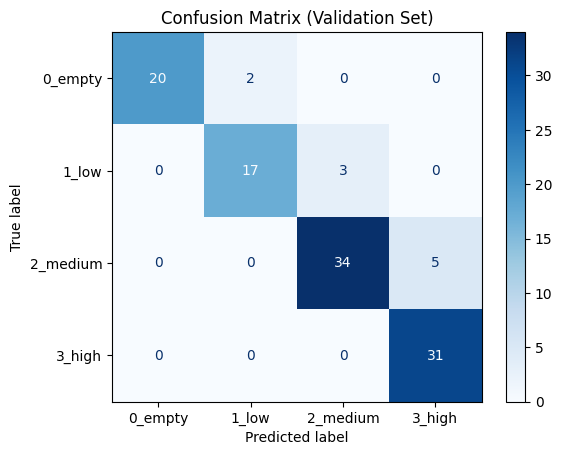

In [52]:
# --- 1. Imports for the matrix ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# --- 2. Make sure model is in 'eval' mode ---
# The 'model' variable already exists from the cell above
model.eval() 

# --- 3. Get All Predictions ---
all_preds = []
all_labels = []

# 'test_loader', 'device', and 'class_names' also exist from the cell above
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 4. Calculate and Plot the Matrix ---
print("--- Confusion Matrix ---")
cm = confusion_matrix(y_true=all_labels, y_pred=all_preds)

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.show()